In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io

import os, re

import claude.utils as cu
import claude.claudeflow.autoencoder as ae
import claude.claudeflow.helper as cfh
import claude.claudeflow.training as cft

In [2]:
seed = 42
tf.set_random_seed(seed)
np.random.seed(seed)

# Parameters
# Channel Parameters
chParam = cu.AttrDict()
chParam.M = 16

# Auto-Encoder Parameters
aeParam = cu.AttrDict()
aeParam.constellationDim = 2
aeParam.constellationOrder = chParam.M
aeParam.nLayers		= 2
aeParam.nHidden	= 32
aeParam.activation  = tf.nn.selu
aeParam.dropout		= False
aeParam.dtype       = tf.float32

# Training Parameters
trainingParam = cu.AttrDict()
trainingParam.sampleSize	= 512*chParam.M # Increase for better results (especially if M>16)
trainingParam.batchSize 	= 32*chParam.M  # Increase for better results (especially if M>16)
trainingParam.learningRate	= 0.001
trainingParam.displayStep	= 20
trainingParam.path			= 'results_AWGN_end2end'
trainingParam.filename		= 'M{}'.format(chParam.M)
trainingParam.earlyStopping = 250
trainingParam.iterations = 250

# TF constants
two = tf.constant(2,aeParam.dtype)
DIM = tf.constant(aeParam.constellationDim, aeParam.dtype)
PI = tf.constant(np.pi,aeParam.dtype)

In [3]:
# Tx Graph     
X = tf.placeholder( aeParam.dtype, shape=(None, chParam.M) )
enc, enc_seed = ae.encoder(X, aeParam)

# Channel Graph
sigma2_noise = tf.constant(0.1,aeParam.dtype)
noise = tf.sqrt( sigma2_noise )\
            *tf.rsqrt(two)\
            *tf.random_normal(shape=tf.shape(enc),dtype=aeParam.dtype)
channel_out = enc + noise

dec = ae.decoder(channel_out, aeParam)

W0917 07:56:08.645858 139656758703936 deprecation.py:506] From /home/rasmus/.conda/envs/claudeOnline/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [4]:
per_ex_loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=X,logits=dec)

In [5]:
# Loss
correct_prediction = tf.equal(tf.argmax(X,1), tf.argmax(dec,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, aeParam.dtype))
loss = tf.reduce_mean(per_ex_loss)

optimizer = tf.train.AdamOptimizer(learning_rate=trainingParam.learningRate).minimize(loss)

W0917 07:56:09.417371 139656758703936 deprecation.py:323] From /home/rasmus/.conda/envs/claudeOnline/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
metricsDict = {'xentropy':loss, 'accuracy_metric':accuracy}
meanMetricOpsDict, updateOps, resetOps = cft.create_mean_metrics(metricsDict)

W0917 07:56:10.303782 139656758703936 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [7]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

saver = tf.train.Saver()
checkpoint_path = os.path.join(trainingParam.path,'checkpoint',trainingParam.filename,'best')
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
else:
    pass
#     print("Restoring checkpoint...", flush=True)
#     saver.restore(sess=sess,save_path=checkpoint_path)

In [8]:
nBatches = int(trainingParam.sampleSize/trainingParam.batchSize)
bestLoss = 10000

for epoche in range(1, trainingParam.iterations+1):
    sess.run(resetOps)
    for batch in range(0,nBatches):
        data, _, _ = cu.hotOnes(trainingParam.batchSize,(1,0),chParam.M)
        feedDict = {X: data}
        sess.run([optimizer, updateOps], feed_dict=feedDict)

    [outAvgLoss, outAvgAccuracy] = sess.run([meanMetricOpsDict['xentropy'], meanMetricOpsDict['accuracy_metric']], feed_dict=feedDict)

    if outAvgLoss < bestLoss:
        bestLoss = outAvgLoss
        lastImprovement = epoche
        saver.save(sess=sess,save_path=checkpoint_path)

    if epoche - lastImprovement > trainingParam.earlyStopping:
        print("Breaking due to no improvement")
        break;

    if epoche%trainingParam.displayStep == 0:
        print('epoche: {} - avgLoss: {} - avgAcc: {}'.format(epoche,outAvgLoss,outAvgAccuracy))

epoche: 20 - avgLoss: 0.6990486979484558 - avgAcc: 0.7659912109375
epoche: 40 - avgLoss: 0.5796283483505249 - avgAcc: 0.782958984375
epoche: 60 - avgLoss: 0.5354400873184204 - avgAcc: 0.7965087890625
epoche: 80 - avgLoss: 0.5532417297363281 - avgAcc: 0.79736328125
epoche: 100 - avgLoss: 0.5578113198280334 - avgAcc: 0.797119140625
epoche: 120 - avgLoss: 0.5328306555747986 - avgAcc: 0.800537109375
epoche: 140 - avgLoss: 0.5588166117668152 - avgAcc: 0.7838134765625
epoche: 160 - avgLoss: 0.5384258031845093 - avgAcc: 0.7989501953125
epoche: 180 - avgLoss: 0.5365269780158997 - avgAcc: 0.8017578125
epoche: 200 - avgLoss: 0.535810112953186 - avgAcc: 0.7987060546875
epoche: 220 - avgLoss: 0.5383657217025757 - avgAcc: 0.8013916015625
epoche: 240 - avgLoss: 0.5349321365356445 - avgAcc: 0.80078125


W0917 07:56:25.151086 139656758703936 deprecation.py:323] From /home/rasmus/.conda/envs/claudeOnline/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


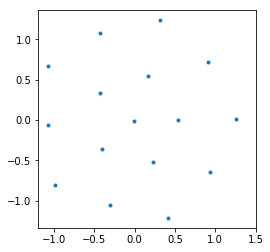

In [9]:
saver.restore(sess=sess,save_path=checkpoint_path)
data, idx, xseed = cu.hotOnes(trainingParam.batchSize,(1,0),chParam.M)
feedDict = {X: xseed}
pred_const = sess.run(enc_seed, feed_dict=feedDict)
plt.plot(pred_const[:,0],pred_const[:,1],'.')
plt.axis('square');